# MP1 - Boyer Romain
## I - Fonctions

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import math

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 50 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((72,72))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

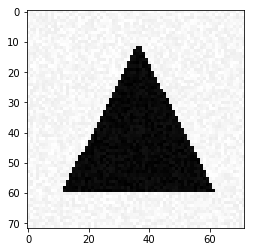

In [2]:
[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(72,72), cmap='gray')

In [3]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.models import Sequential
from keras.utils import np_utils 
from keras import optimizers
from keras.wrappers.scikit_learn import KerasRegressor

Using TensorFlow backend.


### 5 - A Regression Problem
#### a - Ordering the triangle

In [4]:
'''
Let's try to organize the vertices such as the nearest of the origin is the first point, and the farest one is the third one.
Then we will try the model on this cleaned dataset
Let's hava no noise to simplify the problem in a first step
'''
def generate_a_smart_triangle(noise=0.0):
    figsize = 1.0
    U = np.random.random(3)
    V = np.random.random(3)

    imdata = generate_a_drawing(figsize, U, V, noise)

    X_0 = [np.sqrt(U[0]**2 + V[0]**2), U[0], V[0]]
    X_1 = [np.sqrt(U[1]**2 + V[1]**2), U[1], V[1]]
    X_2 = [np.sqrt(U[2]**2 + V[2]**2), U[2], V[2]]
    
    X = [X_0, X_1, X_2]
    X.sort(key=lambda x: x[0])
    
    return [imdata, [X[0][1], X[0][2], X[1][1], X[1][2], X[2][1], X[2][2]]]

def generate_smart_dataset_regression(nb_samples, noise=0):
    # Getting im_size:
    im_size = generate_a_smart_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 50 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_smart_triangle()
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

In [5]:
[X_train, Y_train] = generate_smart_dataset_regression(600)
X_train = X_train.reshape(-1,72,72,1)

Creating data:
0
50
100
150
200
250
300
350
400
450
500
550


In [6]:
def model_():
    model = Sequential()

    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (72,72,1)))
    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25)) # prevent overfitting

    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))

    model.add(Dense(6))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

estimator = KerasRegressor(build_fn=model_, nb_epoch=1, batch_size=20, verbose=1)

In [7]:
estimator.fit(X_train, Y_train, epochs=10, verbose=1)

Epoch 1/10
600/600 [==============================] - 32s 53ms/step - loss: 0.1330

In [8]:
[X, Y] = generate_a_smart_triangle()
X = X.reshape(-1,72,72,1)
prediction = estimator.predict(X)
print(prediction)

1/1 [==============================] - 0s 46ms/step
[ 57.93276    50.5298    175.80313     7.2846723 102.371574  179.99745  ]


In [9]:
'''
The result might be in an other base. Let's try to fix this with a a base changement.
First, draw a triangle with vertices (0,0), (1,0) and (0,1)
Then compute the prediction of this triangle with our model.
Then, compute the passage matrix.
End compute the matrix product between predictions points and our passage matrix
'''

def triangle_base(noise=0):
    figsize = 1.0
    U = [0,1,0]
    V = [0,0,1]

    imdata = generate_a_drawing(figsize, U, V, noise)
    
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

[X_base, Y_base] = triangle_base()

X_base = X_base.reshape(-1,72,72,1)
Y_s = estimator.predict(X_base)


# Y_s_2 is the new base with (0,0) as origin
# Y_base_2 is the old base

Y_s_2 = np.array([[Y_s[2]-Y_s[0], Y_s[4]-Y_s[0]], [ Y_s[3]-Y_s[1], Y_s[5]-Y_s[1]]])
Y_base_2 = np.array([[1,0], [0,1]])

P_mat = np.dot(Y_base_2, np.linalg.inv(Y_s_2))
print(P_mat)

1/1 [==============================] - 0s 20ms/step
[[ 0.01060982 -0.00886886]
 [-0.00579356  0.01542454]]


1/1 [==============================] - 0s 23ms/step
Prediction : [ 57.93276    50.5298    175.80313     7.2846723 102.371574  179.99745  ]
True vertices : [0.7574924024065957, 0.3480167507580343, 0.7847901198638488, 0.46185982148491567, 0.8794263048140055, 0.4521287811413195]
Final pred : [0.57497873 0.4116539 ][0.80008669 0.31999839][0.92940516 0.40989237]


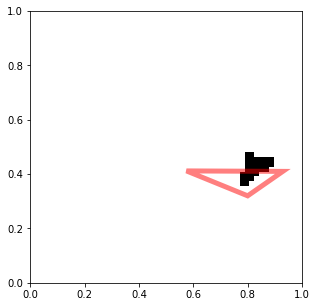

In [26]:
# Generate a triangle
[X, Y] = generate_a_smart_triangle()
X = X.reshape(-1,72,72,1)
Y_e = estimator.predict(X)
print('Prediction : '+str(prediction))
print('True vertices : '+str(Y))

# Compute the new coordinaates => doesn' work
A = np.dot(P_mat, np.array([Y_e[0]-Y_s[0], Y_e[1]-Y_s[1]]))
B = np.dot(P_mat, np.array([Y_e[2]-Y_s[0], Y_e[3]-Y_s[1]]))
C = np.dot(P_mat, np.array([Y_e[4]-Y_s[0], Y_e[5]-Y_s[1]]))
print('Final pred : '+str(A)+str(B)+str(C))

# Plot
visualize_prediction(X, np.array([A[0], A[1], B[0], B[1], C[0], C[1]]))

1/1 [==============================] - 0s 34ms/step
Prediction : [ 57.93276    50.5298    175.80313     7.2846723 102.371574  179.99745  ]
True vertices : [0.23432072688542638, 0.4224836336775327, 0.5487420202378974, 0.07194148999488248, 0.8213926466152982, 0.07709209942239192]
Final pred : [0.30827122 0.46323826][ 0.86339112 -0.21324191][ 1.52370267 -0.54082408]


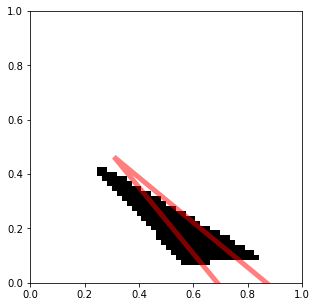

In [33]:
# Generons un triangle
[X, Y] = generate_a_smart_triangle()
X = X.reshape(-1,72,72,1)
Y_e = estimator.predict(X)
print('Prediction : '+str(prediction))
print('True vertices : '+str(Y))

# Calculons les coordonnées du premier sommet => marche pas !!!!!
A = np.dot(P_mat, np.array([Y_e[0]-Y_s[0], Y_e[1]-Y_s[1]]))
B = np.dot(P_mat, np.array([Y_e[2]-Y_s[0], Y_e[3]-Y_s[1]]))
C = np.dot(P_mat, np.array([Y_e[4]-Y_s[0], Y_e[5]-Y_s[1]]))
print('Final pred : '+str(A)+str(B)+str(C))

# Plot
visualize_prediction(X, np.array([A[0], A[1], B[0], B[1], C[0], C[1]]))